In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import matplotlib as mpl
from typing import List
import pandas as pd


# Neural Modelling exercise 2: Prediction learning
Hand-in by Friday, 8.11.24 (midnight) to neuralmodelling24@gmail.com
If you are handing in as a two person team, make sure to put both of your
names on your solution (please hand in only one report per team). Besides your
responses to the questions in text form, your submission should contain your
code. You could e.g. link to a Github repo or submit your report as a Jupyter
notebook.


## Conditioning (Lecture 2)

1. Simulate data for each of the following conditioning paradigms:

    - Blocking
    - Inhibitory conditioning
    - Overshadowing
    - Secondary conditioning
    - Explaining away
    
    To do this, generate arrays which correspond to the sequences of presented
    stimuli and the sequences of presented rewards (ignore time within a trial
    for this, each entry is one trial). Also generate an idealised sequence of
    expectations of rewards of the animal (the expectation occurs after the
    presentation of the CS but before the potential presentation of a reward).
2. Now use the Rescorla-Wagner rule to learn these expectations, based on
the stimulus and reward vectors you generated.

In [2]:
cmap = mpl.colormaps["tab10"]


def v(w: np.ndarray, u: np.ndarray) -> float:
    """compute expected value

    Args:
        w (np.ndarray): (n_stimuli)
        u (np.ndarray): (n_stimuli)

    Returns:
        float: expected value
    """
    return np.dot(w, u)


def plot_stimulus(stim_0, stim_1, reward):
    fig, ax = plt.subplots(figsize = (8, 5))
    mapable = ax.imshow(np.stack([stim_0, stim_1, reward]), cmap = "cividis", vmin = 0, vmax = 1)
    ax.set_aspect(5)
    ax.set_yticks(np.arange(0, 3), labels = ["Stimulus 0", "Stimulus 1", "Reward"])
    ax.set_xlabel("trials")
    fig.colorbar(mapable, location = "right", label = "stimulus strength", fraction = 0.01)
    ax.set_title("Stimulus")


def learn(u: np.ndarray, reward, learning_rate: float) -> Tuple[np.ndarray, np.ndarray]:
    v_exp = np.empty(len(u))
    w = np.zeros_like(u)
    for i in range(u.shape[0] - 1):
        v_exp[i] = v(w[i], u[i])
        delta = learning_rate * (reward[i] - v_exp[i]) * u[i]
        w[i + 1] = w[i] + delta

    v_exp[-1] = v(w[-1], u[-1])

    return w, v_exp

def test_trial(w):
    expected_reward = v(np.array([[0, 0], [0, 1], [1, 0], [1, 1]]), w).reshape(2, 2)

    print("expected_reward in test trial")
    print(pd.DataFrame(expected_reward, columns=["stim_0 = 0", "stim_0 = 1"], index=["stim_1 = 0", "stim_1 = 1"]))


def plot_riscorla_wagner(w, v_exp: np.ndarray, expectations: List[np.ndarray] = [], title: str = ""):
    fig, axs = plt.subplots(nrows=2, sharex=True)
    
    for i in range(w.shape[1]):
        axs[0].plot(w[:, i], label = rf"$w_{i}$")

    for idx, expect in enumerate(expectations):
        axs[0].plot(expect, label = rf"expected: $w_{idx}$", linestyle = "--", color = cmap(w.shape[1] + idx))

    axs[0].legend(loc = "center left", bbox_to_anchor = (1, 0.5))
    axs[0].set_title(title)

    axs[0].set_ylabel("magnitude")

    axs[1].plot(v_exp, label="expected reward")
    axs[1].set_xlabel("trials")
    axs[1].set_ylabel("expected reward")
    axs[1].legend()



n_pretraining = 50
n_trials = 100
learning_rate = 0.15

In [3]:
expected_reward = (np.array([[0, 0], [0, 1], [1, 0], [1, 1]]) @  np.array([1, 0])).reshape(2, 2)


print("expected_reward")
pd.DataFrame(expected_reward, columns=["stim_0 = 0", "stim_0 = 1"], index=["stim_1 = 0", "stim_0 = 1"])

expected_reward


,stim_0 = 0,stim_0 = 1
stim_1 = 0,0,0
stim_0 = 1,1,1


### Blocking


expected_reward in test trial
            stim_0 = 0  stim_0 = 1
stim_1 = 0    0.000000    0.000148
stim_1 = 1    0.999852    1.000000


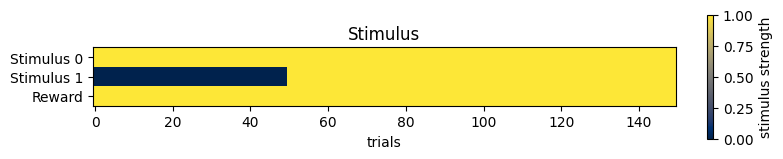

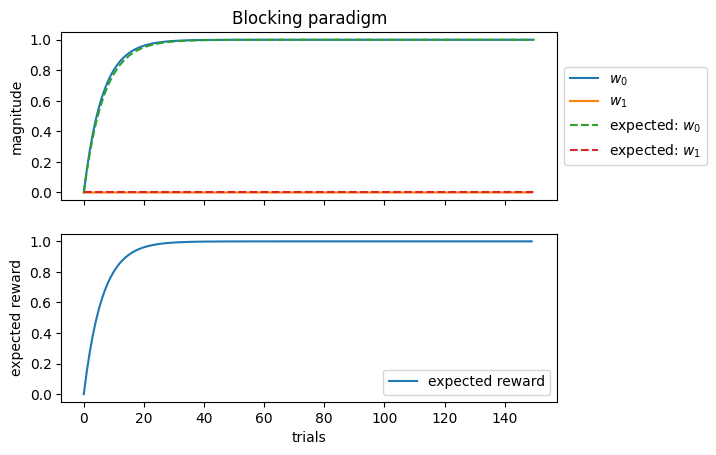

In [4]:
stim_0 = np.ones(n_pretraining + n_trials)
stim_1 = np.ones_like(stim_0)
stim_1[:n_pretraining] = 0
reward = np.ones_like(stim_0)

u = np.stack([stim_0, stim_1]).T  # shape (trials, n_stimuli)

plot_stimulus(stim_0, stim_1, reward)
expect_0 = 1 - np.exp(-np.arange(n_pretraining + n_trials + 1) * learning_rate)
expect_1 = np.zeros(n_pretraining + n_trials + 1)
w, v_exp = learn(u, reward, learning_rate)
plot_riscorla_wagner(w=w, v_exp=v_exp, expectations = [expect_0, expect_1], title = "Blocking paradigm")
test_trial(w[-1])

### Inhibitory Conditioning

expected_reward in test trial
            stim_0 = 0  stim_0 = 1
stim_1 = 0    0.000000   -0.937421
stim_1 = 1    0.957238    0.019817


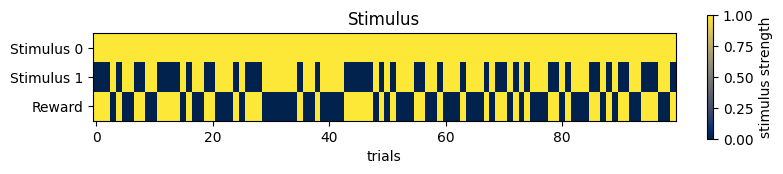

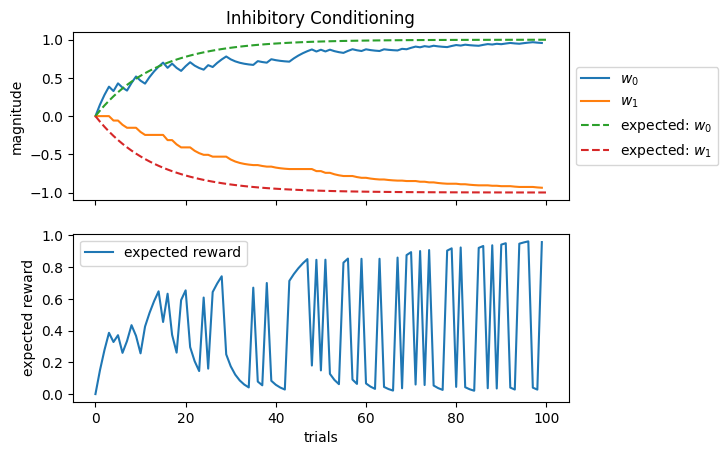

In [10]:
stim_0 = np.ones(n_trials)
stim_1 = np.random.sample(n_trials) > 0.5
reward = (~stim_1).astype(int)

u = np.stack([stim_0, stim_1]).T  # shape (trials, n_stimuli)

plot_stimulus(stim_0, stim_1, reward)
expect_0 = 1 - np.exp(-np.arange(n_trials + 1) * learning_rate * 0.5)
expect_1 = np.exp(-np.arange(n_trials + 1) * learning_rate * 0.5) - 1
w, v_exp = learn(u, reward, learning_rate)
plot_riscorla_wagner(w=w, v_exp=v_exp, expectations = [expect_0, expect_1], title = "Inhibitory Conditioning")
test_trial(w[-1])

In [34]:
w_stack = []
v_exp_stack = []
for _ in range(10000):
    stim_0 = np.ones(n_trials)
    stim_1 = np.random.sample(n_trials) > 0.5
    reward = (~stim_1).astype(int)

    u = np.stack([stim_0, stim_1]).T  # shape (trials, n_stimuli)

    w, v_exp = learn(u, reward, learning_rate)
    w_stack.append(w)
    v_exp_stack.append(v_exp)

w_stack = np.stack(w_stack)
v_exp_stack = np.stack(v_exp_stack)

Text(0, 0.5, 'expected reward')

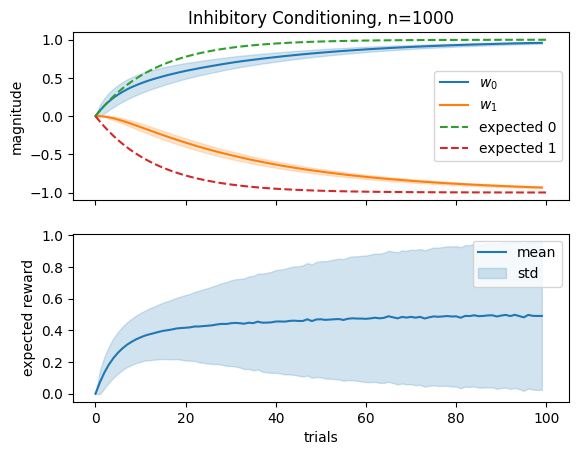

In [57]:
w_stack.shape

mean = w_stack.mean(axis = 0)
std = w_stack.std(axis = 0)

fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(mean[:, 0], c = cmap(0), label = rf"$w_0$")
ax[0].plot(mean[:, 1], c = cmap(1), label = rf"$w_1$")

ax[0].fill_between(np.arange(len(mean)), mean[:, 0] - std[:, 0], mean[:, 0] + std[:, 0], alpha = 0.2, color = cmap(0))
ax[0].fill_between(np.arange(len(mean)), mean[:, 1] - std[:, 1], mean[:, 1] + std[:, 1], alpha = 0.2, color = cmap(1))

expect_0 = 1 - np.exp(-np.arange(n_trials + 1) * learning_rate * 0.5)
expect_1 = np.exp(-np.arange(n_trials + 1) * learning_rate * 0.5) - 1
ax[0].plot(expect_0, linestyle = "--", color = cmap(2), label="expected 0")
ax[0].plot(expect_1, linestyle = "--", color = cmap(3), label="expected 1")

ax[0].set_title("Inhibitory Conditioning, n=1000")
ax[0].legend()
ax[0].set_ylabel("magnitude")
ax[1].set_xlabel("trials")

mean = v_exp_stack.mean(axis = 0)
std = v_exp_stack.std(axis = 0)
ax[1].plot(mean, label="mean")
# ax[1].plot(v_exp_stack[:50].T, c=cmap(0), alpha=0.1)
ax[1].fill_between(np.arange(len(mean)), mean - std, mean + std, alpha = 0.2, color = cmap(0), label="std")
ax[1].legend()
ax[1].set_ylabel("expected reward")


[[ 0.92790202 -0.90153034]
 [ 0.95974369 -0.94306559]
 [ 0.9310459  -0.92891942]
 ...
 [ 0.94519171 -0.93581031]
 [ 0.94322244 -0.8968727 ]
 [ 0.95028206 -0.93092726]]
expected_reward in test trial
            stim_0 = 0  stim_0 = 1
stim_1 = 0    0.000000   -0.934059
stim_1 = 1    0.959329    0.025270


Text(0.5, 0.98, 'Expected Reward Distribution')

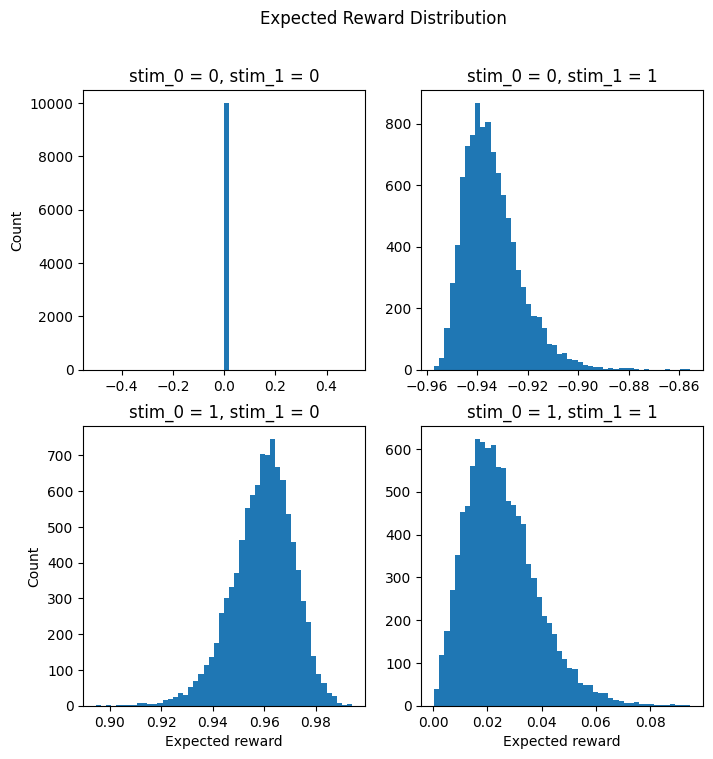

In [64]:
v_test = w_stack[:, -1] @ np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T
v_test = v_test.reshape(-1, 2, 2)
print(w_stack[:, -1])
print("expected_reward in test trial")
print(pd.DataFrame(v_test.mean(axis=0), columns=["stim_0 = 0", "stim_0 = 1"], index=["stim_1 = 0", "stim_1 = 1"]))


fig, axs = plt.subplots(ncols=2, nrows=2, sharey=False, figsize=(8, 8))
axs[0, 0].hist(v_test[:, 0, 0], bins=50)
axs[0, 0].set_title("stim_0 = 0, stim_1 = 0")
axs[0, 1].hist(v_test[:, 0, 1], bins=50)
axs[0, 1].set_title("stim_0 = 0, stim_1 = 1")
axs[1, 0].hist(v_test[:, 1, 0], bins=50)
axs[1, 0].set_title("stim_0 = 1, stim_1 = 0")
axs[1, 1].hist(v_test[:, 1, 1], bins=50)
axs[1, 1].set_title("stim_0 = 1, stim_1 = 1")

axs[0, 0].set_ylabel("Count")
axs[1, 0].set_ylabel("Count")
axs[1, 1].set_xlabel("Expected reward")
axs[1, 0].set_xlabel("Expected reward")
fig.suptitle("Expected Reward Distribution")

### Overshadowing

expected_reward in test trial
            stim_0 = 0  stim_0 = 1
stim_1 = 0         0.0         0.5
stim_1 = 1         0.5         1.0


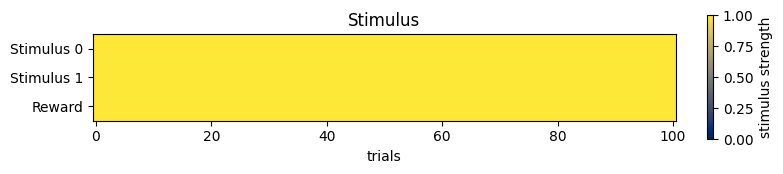

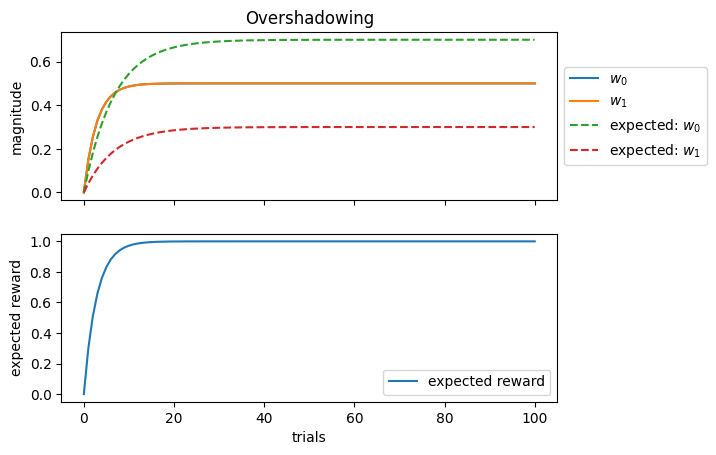

In [65]:
stim_0 = np.ones(n_trials + 1)
stim_1 = np.ones(n_trials + 1)
reward = np.ones(n_trials + 1)
u = np.stack([stim_0, stim_1]).T

plot_stimulus(stim_0, stim_1, reward)
expect_0 = (1 - np.exp(-np.arange(n_trials + 1) * learning_rate)) * 0.7
expect_1 = (1 - np.exp(-np.arange(n_trials + 1) * learning_rate)) * 0.3
w, v_exp = learn(u, reward, learning_rate)
plot_riscorla_wagner(w=w, v_exp=v_exp, expectations = [expect_0, expect_1], title = "Overshadowing")
test_trial(w[-1])

### Secondary Conditioning

expected_reward in test trial
            stim_0 = 0    stim_0 = 1
stim_1 = 0    0.000000 -4.998521e-01
stim_1 = 1    0.499852  3.330669e-16


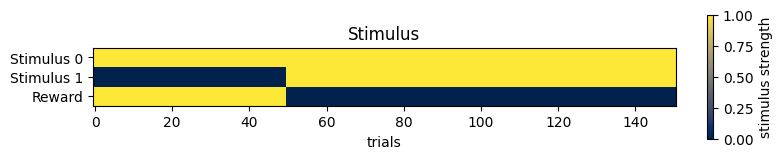

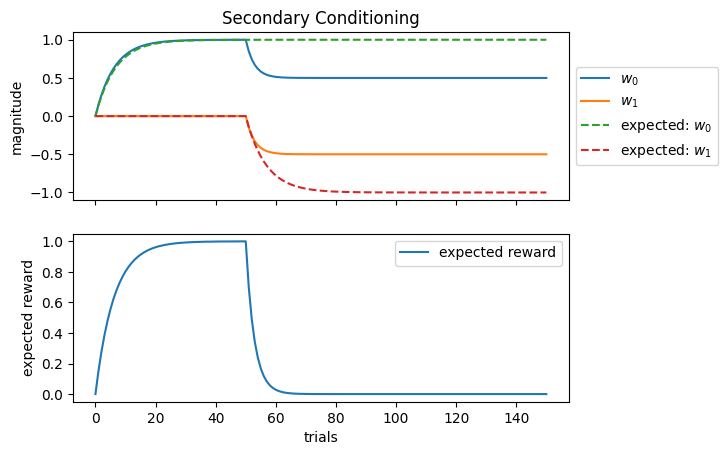

In [66]:
stim_0 = np.ones(n_pretraining + n_trials + 1)
stim_1 = np.ones(n_pretraining + n_trials + 1)
stim_1[:n_pretraining] *= 0
reward = np.zeros(n_pretraining + n_trials + 1)
reward[:n_pretraining] = 1
u = np.stack([stim_0, stim_1]).T

plot_stimulus(stim_0, stim_1, reward)
expect_0 = 1 - np.exp(-np.arange(n_pretraining + n_trials + 1) * learning_rate)
expect_1 = np.zeros_like(expect_0)
expect_1[n_pretraining:] = np.exp(-np.arange(n_trials + 1) * learning_rate) - 1
w, v_exp = learn(u, reward, learning_rate)
plot_riscorla_wagner(w=w, v_exp=v_exp, expectations = [expect_0, expect_1], title = "Secondary Conditioning")
test_trial(w[-1])

### Explaining Away

expected_reward in test trial
            stim_0 = 0  stim_0 = 1
stim_1 = 0         0.0         0.5
stim_1 = 1         1.0         1.5


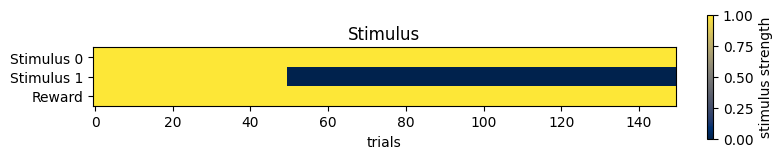

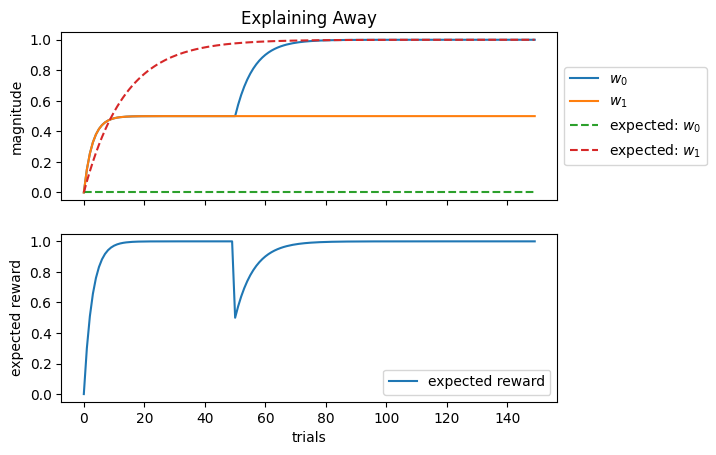

In [178]:
stim_0 = np.ones(n_pretraining + n_trials)
stim_1 = np.ones(n_pretraining + n_trials)
stim_1[n_pretraining:] = 0
reward = np.ones_like(stim_0)

u = np.stack([stim_0, stim_1]).T  # shape (trials, n_stimuli)

plot_stimulus(stim_0, stim_1, reward)
expect_1 = 1 - np.exp(-np.arange(n_pretraining + n_trials) * learning_rate * 0.5)
expect_0 = np.zeros_like(expect_1)
w, v_exp = learn(u, reward, learning_rate)
plot_riscorla_wagner(w=w, v_exp=v_exp, expectations = [expect_0, expect_1], title = "Explaining Away")
test_trial(w[-1])

3. For which paradigms do your learned expectations qualitatively agree with
your idealised predictions? For the non-matching paradigms, speculate
why the Rescorla-Wagner rule failed to produce the correct expectations.

For secondary conditioning.
We assume this discrepancy comes from the fact that RW only creates a association from stimulus to reward and not stimulus to another stimulus.  

## Extinction (Lecture 3)

In an extinction protocol, animals repeatedly encounter a previously learned
CS, but without receiving the corresponding punishment. However, in certain
conditions, the learned association can resurface. We will work towards one
way of modelling this, using state-based inference. (Remember: A state, or
latent cause, is the context which an animal infers to make predictions about
its environment.)

For this exercise please note that for this exercise we denote `state_0` as the state in which the animal is getting shocked after the tone and `state_1` is the state in which the animal only gets the tone.

In [179]:
n_pretraining = 50
n_training = 50
n_pause = 30

def plot_belief(belief: np.ndarray):
    # two states -> shocked and not shocked

    fig, ax = plt.subplots()
    ax.axvspan(-0.5, n_pretraining - 0.5, alpha = 0.2, color = cmap(2), label = "pretrain")
    ax.axvspan(
        -0.5 + n_pretraining,
        n_pretraining + n_pretraining - 0.5,
        alpha = 0.2,
        color = cmap(3),
        label = "train",
    )
    ax.axvspan(
        -0.5 + n_pretraining + n_pretraining,
        n_pretraining + n_pretraining + n_pause - 0.5,
        alpha = 0.2,
        color = cmap(4),
        label = "pause",
    )
    ax.axvspan(
        -0.5 + n_pretraining + n_pretraining + n_pause,
        n_pretraining + n_pretraining + n_pause + 1,
        alpha = 0.2,
        color = cmap(5),
        label = "test",
    )
    ax.plot(belief, label = "belief state_0", color = cmap(0))
    ax.plot(1 - belief, label = "belief state_1", color = cmap(1))

    ax.legend()
    ax.set_xlabel("days")
    ax.set_ylabel("belief")

    return fig, ax

- An animal first encounters 50 conditioning trials in a row, then, on the
next day, 50 extinction trials in a row. Finally, after a substantial delay
of 30 days, it encounter the CS again, for one single trial. Design an
appropriate array which could describe the belief of the animal about the
current state of the environment on each trial, right before receiving the
CS. (Hint: How many states do you need? At which points in time do
they change?)

Text(0.5, 1.0, 'Stimulus')

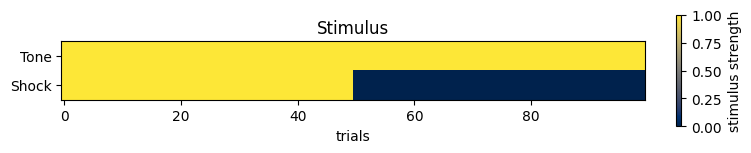

In [180]:


pretraining = np.ones(n_pretraining)
training = np.zeros(n_training)
test = np.ones(1)
shock = np.concatenate([pretraining, training])
tone = np.concatenate([np.ones_like(pretraining), np.ones_like(training)], )

fig, ax = plt.subplots(figsize = (8, 5))
mapable = ax.imshow(np.stack([tone, shock]), cmap = "cividis", vmin = 0, vmax = 1)
ax.set_aspect(5)
ax.set_yticks(np.arange(0, 2), labels = ["Tone", "Shock"])
ax.set_xlabel("trials")
fig.colorbar(mapable, location = "right", label = "stimulus strength", fraction = 0.009)
ax.set_title("Stimulus")


Text(0.5, 1.0, 'Expected Behavior')

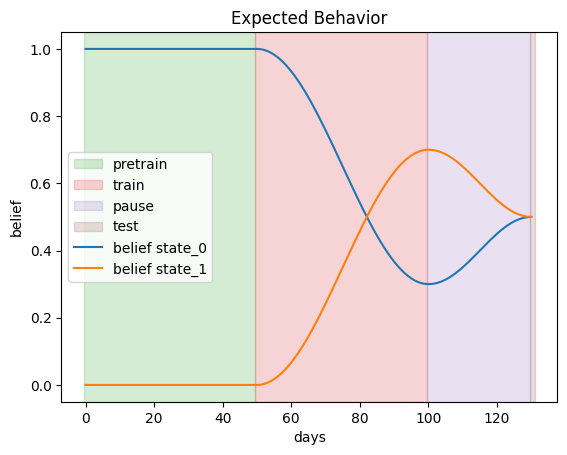

In [181]:
after_train_believe = 0.7
p_shocked = np.concatenate(
    [
        np.ones(n_pretraining),
        after_train_believe / 2 * np.cos(np.arange(n_training) / n_training * np.pi)
        + 1
        - (after_train_believe / 2),
        -(after_train_believe - 0.5)
        / 2
        * np.cos(np.arange(n_pause + 1) / n_pause * np.pi)
        + (1 - after_train_believe)
        + (after_train_believe - 0.5) / 2,
    ]
)

fig, ax = plot_belief(p_shocked)
ax.set_title("Expected Behavior")


- Using this belief array, plot the animal’s expectation of receiving the US
after the CS on each trial. (For this part of the exercise, ignore the learning
of the CS-US relationship, assume that the animal perfectly knows the
connection between CS and US for each state).

Text(0.5, 1.0, 'Perfect Learning')

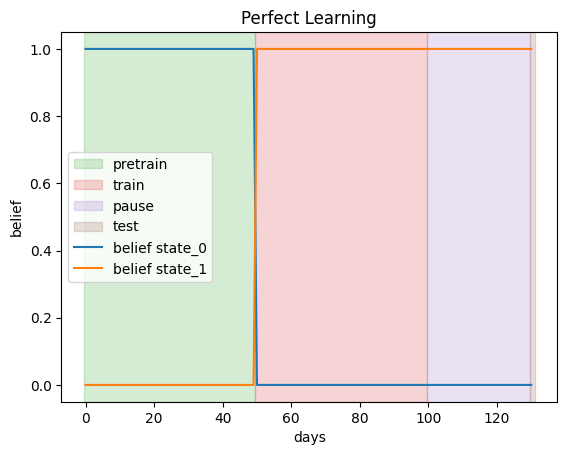

In [182]:
perfect_learning = np.concatenate([
    np.ones(n_pretraining),
    np.zeros(n_training + n_pause + 1)
])

fig, ax = plot_belief(perfect_learning)
ax.set_title("Perfect Learning")

The expectation and believe are the same because the expectation of a binary event is the probability of the binary event. 

- Now, rather than assuming our state belief array, we will infer it ourselves
with a simple heuristic. Write a function which takes three inputs: The
state of the previous trial, the similarity of the previous trial to the one
before it in terms of made observations, and the amount of time which
passed since the last trial. Based on these arguments, return a belief over
all states which are under consideration. On the first trial, the animal is
100% certain of being in state 1. (We don’t expect any specific functional
form for this function, but it should qualitatively recreate your belief array
from the first part of this exercise).

Text(0.5, 1.0, 'Belief with Riscorla-Wagner')

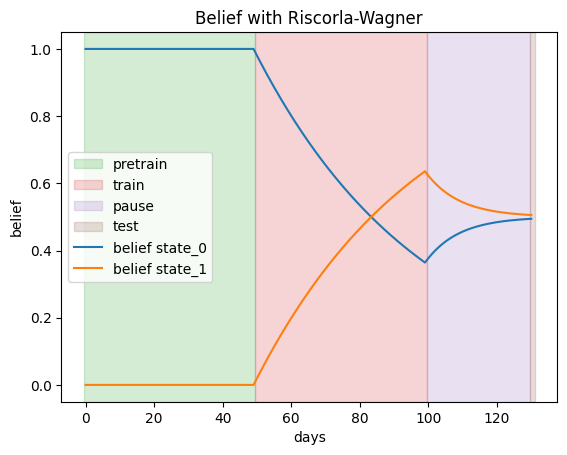

In [183]:
def update_state_0(prev_belief_state_0: np.ndarray, similarity: float, pause: int):
    forget_rate = 0.1
    for _ in range(pause):
        delta = forget_rate * (0.5 - prev_belief_state_0)
        prev_belief_state_0 += delta

    learning_rate = 0.02
    # assume 2 dimensional observation space
    delta = learning_rate * ((similarity - 1) - prev_belief_state_0)
    prev_belief_state_0 += delta

    return prev_belief_state_0


observations = np.stack([tone, shock]).T
state_belief_state_0 = np.empty(n_training + n_pretraining + n_pause + 1)
state_belief_state_0[0] = 1
for i in range(1, n_pretraining + n_training + n_pause + 1):
    # just for displaying purposes -> same thing as just putting in the 30 day pause into update_state_0
    if i >= n_pretraining + n_training:
        similarity = state_belief_state_0[i - 1] + 1
        pause = 1
    else:
        similarity = np.dot(*observations[i - 1: i + 1])
        pause = 0
    state_belief_state_0[i] = update_state_0(
        prev_belief_state_0 = state_belief_state_0[i - 1],
        similarity = similarity,
        pause = pause,
    )

fig, ax = plot_belief(state_belief_state_0)
ax.set_title("Belief with Riscorla-Wagner")

- Finally, maintain a learned association strength between CS and US for
each state separately. Update them after each trial according to the
Rescorla-Wagner rule, but also weigh the magnitude of the update by
the strength of the belief in the state. For simplicity, assume that the
belief about the current state does not change between the beginning and
the end of each trial.

In [184]:
# Define stimuli
stimulusA = np.ones(n_pretraining + n_training).astype(bool)

# Define rewards
rewards = np.concatenate([
    np.ones(n_pretraining),
    np.zeros(n_training)
]).astype(bool)

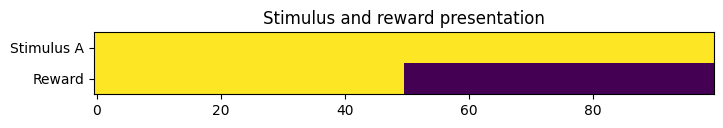

In [185]:
_, ax = plt.subplots(figsize = (8, 5))

plt.imshow([stimulusA, rewards], aspect = "equal")

ax.set_aspect(5)
ax.set_yticks(np.arange(0, 2), labels = ["Stimulus A", "Reward"])
plt.title("Stimulus and reward presentation")

plt.show()

In [186]:
def update_state_0(prev_belief_state_0: np.ndarray, similarity: float, pause: int):
    forget_rate = 0.1
    for _ in range(pause):
        delta = forget_rate * (0.5 - prev_belief_state_0)
        prev_belief_state_0 += delta

    learning_rate = 0.15
    # assume 2 dimensional observation space
    delta = learning_rate * ((similarity - 1) - prev_belief_state_0)
    prev_belief_state_0 += delta

    return prev_belief_state_0

# stimuli
u = tone
alpha = learning_rate
r = shock

# predicted rewards
vA = np.zeros(shape = (n_pretraining + n_training, 1))
vB = np.zeros(shape = (n_pretraining + n_training, 1))
# weights for state A - tone -> shock
wA = np.zeros(shape = (n_pretraining + n_training, 1))
wB = np.zeros(shape = (n_pretraining + n_training, 1))

# Belief about the state A
state_belief_state_0 = np.empty(n_training + n_pretraining)
state_belief_state_0[0] = 1

observations = np.stack([tone, shock]).T

for i in range(1, n_pretraining + n_training):
    similarity = np.dot(*observations[i - 1: i + 1])
    pause = 0
    state_belief_state_0[i] = update_state_0(
        prev_belief_state_0 = state_belief_state_0[i - 1],
        similarity = similarity,
        pause = pause
    )

    v_exp = np.sum(vA[i - 1])
    delta_w = alpha * (r[i - 1] - v_exp) * u[i - 1]
    wA[i] = wA[i - 1] + delta_w * state_belief_state_0[i]
    vA[i] = wA[i] * u[i]

    # TODO: not sure if correct!!!
    v_exp = np.sum(vB[i - 1])
    delta_w = alpha * (r[i - 1] - v_exp) * u[i - 1]
    wB[i] = wB[i - 1] + delta_w * (1 - state_belief_state_0[i])
    vB[i] = wB[i] * u[i]

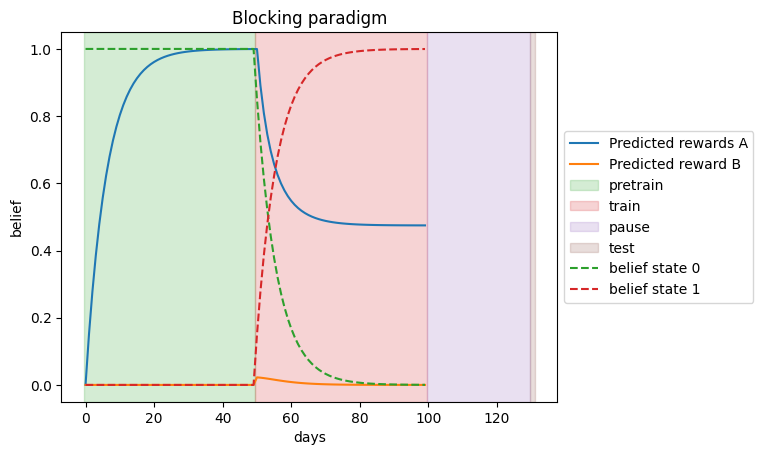

In [187]:
fig, ax = plt.subplots()

ax.plot(wA, label = "Predicted rewards A")
ax.plot(wB, label = "Predicted reward B")

ax.axvspan(-0.5, n_pretraining - 0.5, alpha = 0.2, color = cmap(2), label = "pretrain")
ax.axvspan(
    -0.5 + n_pretraining,
    n_pretraining + n_pretraining - 0.5,
    alpha = 0.2,
    color = cmap(3),
    label = "train"
)
ax.axvspan(
    -0.5 + n_pretraining + n_pretraining,
    n_pretraining + n_pretraining + n_pause - 0.5,
    alpha = 0.2,
    color = cmap(4),
    label = "pause"
)
ax.axvspan(
    -0.5 + n_pretraining + n_pretraining + n_pause,
    n_pretraining + n_pretraining + n_pause + 1,
    alpha = 0.2,
    color = cmap(5),
    label = "test"
)

ax.plot(state_belief_state_0, "--", label = "belief state 0")
ax.plot(1 - state_belief_state_0, "--", label = "belief state 1")
ax.legend()
ax.set_xlabel("days")
ax.set_ylabel("belief")

plt.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.title("Blocking paradigm")

plt.show()